In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_val_predict,
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, RocCurveDisplay

## Data loading and cleaning

We load the .csv and start by looking at the data, so that we know what we are working with.

In [2]:
df = pd.read_csv('task_data.csv')

display(df)
print(df.info())

,ID,Cardiomegaly,Heart width,Lung width,CTR - Cardiothoracic Ratio,xx,yy,xy,normalized_diff,Inscribed circle radius,Polygon Area Ratio,Heart perimeter,Heart area,Lung area
0,1,0,172,405,"0,424691358",1682.360871,3153.671880,-638.531109,-0.304239,"68,8186",0.213446,"679,4873689",24898,75419
1,2,1,159,391,"0,4066496164",1526.660960,5102.159054,-889.678405,-0.539387,"73,92564",0.203652,"788,6589419",29851,94494
2,5,0,208,400,"0,52",2465.903392,5376.834707,-1755.344699,-0.371163,"69,33974",0.320787,"862,3229369",33653,66666
3,7,1,226,435,"0,5195402299",2509.063593,6129.821270,-1025.079806,-0.419123,"84,14868",0.317545,"906,724959",42018,82596
4,8,1,211,420,"0,5023809524",2368.770135,5441.767075,-1493.040062,-0.393442,"73,78347",0.263542,"864,2396777",35346,85631
5,9,1,222,405,"0,5481481481",2351.057355,8378.677729,-812.061371,-0.561768,"83,86298",0.328101,"1001,068103",46381,92755
6,10,1,202,498,"0,40562249",2251.879460,4467.406612,-511.955541,-0.329727,"84,72308",0.209396,"808,2985504",35417,116542
7,11,1,228,474,"0,4810126582",2971.936804,3971.943088,-885.822012,-0.144013,"83,73769",0.242418,"821,9554045",36716,97325
8,12,0,176,449,"0,3919821826",1833.841218,3709.724540,-831.472858,-0.338389,"73,40981",0.181388,"727,9726499",27939,99656
9,13,1,223,473,"0,4714587738",2412.707474,6169.769803,-880.450924,-0.437760,"76,41989",0.261665,"922,9259679",38162,105442


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     object 
 5   xx                          37 non-null     float64
 6   yy                          37 non-null     float64
 7   xy                          37 non-null     float64
 8   normalized_diff             37 non-null     float64
 9   Inscribed circle radius     37 non-null     object 
 10  Polygon Area Ratio          37 non-null     float64
 11  Heart perimeter             37 non-null     object 
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

Our check reveals three critical insights. Firstly there is not much data there, only 37 rows, which we need to remember. Secondly luckily there is no Nulls. And ultimately there are a few columns that we need to fix due to commas being the decimal separators instead of dots.

In [3]:
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].str.replace(',', '.')
    df[column] = pd.to_numeric(df[column])

After cleaning the data we separate the features `X` and the target `y`. After that we divide data into training and test set. We use `random_state=42` to ensure repeatability and `stratify` due to low amount of data so that our training and test set have similar amount of positive and negative cases.

In [4]:
X = df.drop(columns=['ID', 'Cardiomegaly'])
y = df['Cardiomegaly']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Model training

Disclaimer: To make this notebook run quickly I intentionally commented out the process of finding the best hyperparameters and just left the final models with the optimal parameters hard-coded below.
Nevertheless, they are there as "proof-of-work" and can be uncommented and ran if you wish.

### K-Nearest Neighbors (KNN) Classifier

We start of with defining the `param_grid `that is going to be used in finding the best hyperparameters. Then we create a `Pipeline` that first applies a `StandardScaler` before running a classifier. To evaluate the model reliably we also define a `RepeatedStratifiedKFold` which will run 5 splits, repeated 100 times, ensuring our accuracy score is very stable and not just a result of a single lucky data split.

These components are then passed to `GridSearchCV`. Its job is to test all possible combinations from the `param_grid` and find the single best one.



In [5]:
# param_grid = {
#     "model__n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15],
#     "model__weights": ["uniform", "distance"],
#     "model__metric": ["minkowski", "manhattan", "euclidean", "chebyshev"],
# }
#
# rskf = RepeatedStratifiedKFold(
#     n_splits=5,
#     n_repeats=100,
#     random_state=42
# )
#
# pipe_knn = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", KNeighborsClassifier())
# ])
#
# grid_search = GridSearchCV(
#     estimator=pipe_knn,
#     param_grid=param_grid,
#     scoring="accuracy",
#     cv=rskf,
#     verbose=1,
#     n_jobs=-1
# )
#
# grid_search.fit(X_train, y_train)
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best accuracy (averaged CV): {grid_search.best_score_:.4f}")

In the next cell, we take the results from the search above and hard-code them.

We use these specific parameters to create our final pipeline, `pipe_knn_final`. This allows us to instantly create our best-performing model without re-running the search. Finally, we train this optimized pipeline on the entire `X_train` and `y_train` dataset, making it ready for predictions.

We will repeat the same process for all classifiers.

In [7]:
knn_best_params = {'model__metric': 'minkowski', 'model__n_neighbors': 2, 'model__weights': 'distance'} # Values copied from the commented cell above
knn_best_score = 0.8152 # Value copied from the cell above

pipe_knn_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(
        n_neighbors=knn_best_params['model__n_neighbors'],
        weights=knn_best_params['model__weights'],
        metric=knn_best_params['model__metric']
    ))
])

pipe_knn_final.fit(X_train, y_train)

print(f"Best CV Score (from GridSearch): {knn_best_score:.4f}")
print(f"Best Params (from GridSearch): {knn_best_params}")

Best CV Score (from GridSearch): 0.8152
Best Params (from GridSearch): {'model__metric': 'minkowski', 'model__n_neighbors': 2, 'model__weights': 'distance'}


### Decision Tree

In [14]:
# param_grid = {
#     "model__criterion": ["gini", "entropy", "log_loss"],
#     "model__max_depth": [5, 6, 7, 8, None],
#     "model__min_samples_split" : [3, 4, 5, 6, 7, 10],
#     "model__class_weight" : [None, "balanced"],
#     "model__min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9]
# }
#
# rskf = RepeatedStratifiedKFold(
#     n_splits=5,
#     n_repeats=100,
#     random_state=42
# )
#
# pipe_tree = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", DecisionTreeClassifier())
# ])
#
# grid = GridSearchCV(
#     estimator=pipe_tree,
#     param_grid=param_grid,
#     scoring="accuracy",
#     cv=rskf,
#     n_jobs=-1,
#     verbose=1
# )
#
#
# grid.fit(X_train, y_train)
# print(f"\nBest parameters: {grid.best_params_}")
# print(f"Best mean CV accuracy: {grid.best_score_:.4f}")


Fitting 500 folds for each of 1620 candidates, totalling 810000 fits

Best parameters: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 8, 'model__min_samples_split': 6}
Best mean CV accuracy: 0.7381


In [26]:
tree_best_params = {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 8, 'model__min_samples_split': 6} # Values copied from the commented cell above
tree_best_score = 0.7381 # Value copied from the cell above


pipe_tree_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(
    max_depth=tree_best_params["model__max_depth"],
    criterion=tree_best_params["model__criterion"],
    min_samples_split=tree_best_params["model__min_samples_split"],
    min_samples_leaf=tree_best_params["model__min_samples_leaf"],
    class_weight=tree_best_params["model__class_weight"]
))
])


pipe_tree_final.fit(X_train, y_train)

print(f"Best CV Score (from GridSearch): {tree_best_score:.4f}")
print(f"Best Params (from GridSearch): {tree_best_params}")

Best CV Score (from GridSearch): 0.7381
Best Params (from GridSearch): {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 8, 'model__min_samples_split': 6}


### Random Forest

In [36]:
# param_grid = {
#     "model__n_estimators": [25, 50, 75, 100, 150],
#     "model__max_depth": [1, 2, 3, None],
#     "model__min_samples_split": [2, 3, 4],
#     "model__min_samples_leaf": [2, 3, 4, 5, 6, 7],
#     "model__max_features": ["sqrt", "log2"],
#     "model__criterion": ["entropy", "gini"]
# }
#
# rskf = RepeatedStratifiedKFold(
#     n_splits=3,
#     n_repeats=5,
#     random_state=42
# )
#
# pipe_rf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", RandomForestClassifier(random_state=42))
# ])
#
# grid = GridSearchCV(
#     estimator=pipe_rf,
#     param_grid=param_grid,
#     scoring="accuracy",
#     cv=rskf,
#     n_jobs=-1,
#     verbose=1
# )
#
# grid.fit(X_train, y_train)
#
# print(f"Best parameters: {grid.best_params_}")
# print(f"Best mean CV accuracy: {grid.best_score_:.4f}")
#
# # 7. Test na danych testowych
# best_rf = grid.best_estimator_
# y_pred = best_rf.predict(X_test)


Fitting 15 folds for each of 1440 candidates, totalling 21600 fits
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 1, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Best mean CV accuracy: 0.7593


In [39]:
rf_best_params = {'model__criterion': 'entropy', 'model__max_depth': 1, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50} # Values copied from the commented cell above
rf_best_score = 0.7593 # Value copied from the cell above

pipe_rf_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
    max_depth=rf_best_params["model__max_depth"],
    min_samples_split=rf_best_params["model__min_samples_split"],
    n_estimators=rf_best_params["model__n_estimators"],
    min_samples_leaf=rf_best_params["model__min_samples_leaf"],
    max_features=rf_best_params["model__max_features"],
    criterion=rf_best_params["model__criterion"],
    random_state=42
))
])


pipe_rf_final.fit(X_train, y_train)

print(f"Best CV Score (from GridSearch): {rf_best_score:.4f}")
print(f"Best Params (from GridSearch): {rf_best_params}")

Best CV Score (from GridSearch): 0.7593
Best Params (from GridSearch): {'model__criterion': 'entropy', 'model__max_depth': 1, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50}


### Support Vector Machine (SVM)

In [172]:
# param_grid = {
#     "model__kernel": ["linear", "rbf"],
#     "model__C": [0.1, 1, 5, 10, 15, 20, 30, 70, 100],
#     "model__gamma": ["scale", "auto"],
#     "model__class_weight": [None, 'balanced']
# }
#
# rskf = RepeatedStratifiedKFold(
#     n_splits=5,
#     n_repeats=100,
#     random_state=42
# )
#
# pipe_svm = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", SVC())
# ])
#
# grid = GridSearchCV(
#     estimator=pipe_svm,
#     param_grid=param_grid,
#     scoring="accuracy",
#     cv=rskf,
#     n_jobs=-1,
#     verbose=1
# )
#
# grid.fit(X_train, y_train)
#
# print(f"\nBest parameters: {grid.best_params_}")
# print(f"Best mean CV accuracy: {grid.best_score_:.4f}")


Fitting 500 folds for each of 72 candidates, totalling 36000 fits

Best parameters: {'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best mean CV accuracy: 0.8251


In [192]:
svc_best_params = {'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'} # Values copied from the commented cell above
svc_best_score = 0.8251 # Value copied from the cell above


pipe_svc_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel=svc_best_params["model__kernel"],
        C=svc_best_params["model__C"],
        gamma=svc_best_params["model__gamma"],
        class_weight=svc_best_params["model__class_weight"],
        probability = True
    ))
])

pipe_svc_final.fit(X_train, y_train)

print(f"Best CV Score (from GridSearch): {svc_best_score:.4f}")
print(f"Best Params (from GridSearch): {svc_best_params}")

Best CV Score (from GridSearch): 0.8251
Best Params (from GridSearch): {'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


### Logistic Regression

In [55]:
# param_grid = [
#     {
#         "model__solver": ["liblinear"],
#         "model__penalty": ["l1", "l2"],
#         "model__C": [0.001, 0.01, 0.1, 1, 10, 30, 70, 100],
#         "model__class_weight": [None, "balanced"]
#     },
#     {
#         "model__solver": ["lbfgs"],
#         "model__penalty": ["l2"],
#         "model__C": [0.001, 0.01, 0.1, 1, 10, 30, 70, 100],
#         "model__class_weight": [None, "balanced"]
#     }
# ]
#
# rskf = RepeatedStratifiedKFold(
#     n_splits=5,
#     n_repeats=100,
#     random_state=42
# )
#
# pipe_logreg = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", LogisticRegression(max_iter=10000))
# ])
#
# grid = GridSearchCV(
#     estimator=pipe_logreg,
#     param_grid=param_grid,
#     scoring="accuracy",
#     cv=rskf,
#     n_jobs=-1,
#     verbose=1
# )
#
# grid.fit(X_train, y_train)
#
# print(f"\nBest parameters: {grid.best_params_}")
# print(f"Best mean CV accuracy: {grid.best_score_:.4f}")


Fitting 500 folds for each of 48 candidates, totalling 24000 fits

Best parameters: {'model__C': 0.001, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best mean CV accuracy: 0.7600


In [57]:
log_best_params = {'model__C': 0.001, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'} # Values copied from the commented cell above
log_best_score = 0.7600 # Value copied from the cell above

pipe_log_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        C=log_best_params["model__C"],
        penalty=log_best_params["model__penalty"],
        solver=log_best_params["model__solver"],
        max_iter=10000,
        class_weight=log_best_params["model__class_weight"]
    ))
])

pipe_log_final.fit(X_train, y_train)


print(f"Best CV Score (from GridSearch): {log_best_score:.4f}")
print(f"Best Params (from GridSearch): {log_best_params}")


Best CV Score (from GridSearch): 0.7600
Best Params (from GridSearch): {'model__C': 0.001, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


## Assessment of models

We start with creating some dictionaries collecting the models we trained and their data. It will make the analysis easier later.

In [195]:
final_models = {
    "K-Nearest Neighbors": pipe_knn_final,
    "Decision Tree": pipe_tree_final,
    "Random Forest": pipe_rf_final,
    "Support Vector Classifier": pipe_svc_final,
    "Logistic Regression": pipe_log_final
}

best_params = {
    "K-Nearest Neighbors": knn_best_params,
    "Decision Tree": tree_best_params,
    "Random Forest": rf_best_params,
    "Support Vector Classifier": svc_best_params,
    "Logistic Regression": log_best_params
}

best_score = {
    "K-Nearest Neighbors": knn_best_score,
    "Decision Tree": tree_best_score,
    "Random Forest": rf_best_score,
    "Support Vector Classifier": svc_best_score,
    "Logistic Regression": log_best_score
}

We collect the accuracy data in a DataFrame and sort it to see which model performed the best on the training data.

In [137]:
cv_results_df = pd.DataFrame({
    "Model": list(best_score.keys()),
    "Accuracy (Training)": list(best_score.values()),
})

cv_results_df = cv_results_df.sort_values(by="Accuracy (Training)", ascending=False)

cv_results_df = cv_results_df.set_index("Model")

cv_results_df

,Accuracy (Training)
Model,
Support Vector Classifier,0.8251
K-Nearest Neighbors,0.8152
Logistic Regression,0.7600
Random Forest,0.7593
Decision Tree,0.7381


As we can see we achieved the highest accuracy using the SVC model.

Now we apply all models to the test data and after that check their performance using various metrics.

In [114]:
test_metrics = {}
for name, model in final_models.items():
    y_predict = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, zero_division=0)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)

    test_metrics[name] = {
        "Predict" : y_predict,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

We add the accuracy score achieved on the test data to the dataframe we made before.
As we can see the best performing model is the Random Forest one which doest not match with what we got before. (Nevertheless it's mostly due to low amount of data)

In [140]:
cv_results_df["Accuracy (Test)"] = cv_results_df.index.map(lambda m: test_metrics[m]["Accuracy"])

cv_results_df

,Accuracy (Training),Accuracy (Test)
Model,,
Support Vector Classifier,0.8251,0.750
K-Nearest Neighbors,0.8152,0.750
Logistic Regression,0.7600,0.750
Random Forest,0.7593,0.875
Decision Tree,0.7381,0.750


We draw a bar chart to present rest of the metrics.

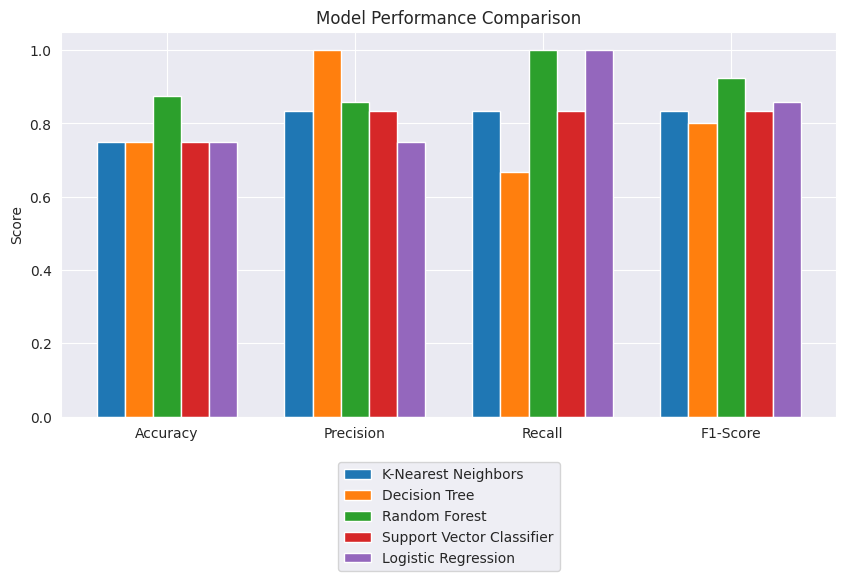

In [143]:
models = list(test_metrics.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

values = [[test_metrics[m][metric] for metric in metrics] for m in models]

x = range(len(metrics))
bar_width = 0.15

plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    plt.bar(
        [p + i * bar_width for p in x],
        values[i],
        width=bar_width,
        label=model
    )

plt.xticks([p + bar_width * (len(models) - 1) / 2 for p in x], metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend(loc="upper center",  bbox_to_anchor=(0.5, -0.1))
plt.show()


### Receiver Operating Characteristic

We use ROC curves to evaluate how well our classifiers distinguish between the two classes according to different decision thresholds. The Area Under the Curve value summarizes the model’s ability to separate the classes — the closer it is to 1.0, the better the model performs.

As we can see in our case both the Logistic Regression and Random Forest perform the best with `AUC = 0.92`

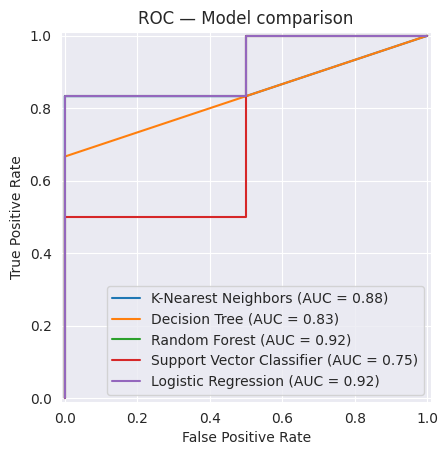

In [174]:
fig, ax = plt.subplots()

for name, model in final_models.items():
    RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        ax=ax,
        name=name,
        pos_label=1
    )

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC — Model comparison")
ax.legend(loc="lower right")
plt.show()

## Voting Classifier

We create a `Voting Classifier` to combine all our models into one.

In [206]:
pipe_voting_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", VotingClassifier(
        estimators=list(final_models.items()),
        voting="soft"
    ))
])

pipe_voting_final.fit(X_train, y_train)
y_pred_voting = pipe_voting_final.predict(X_test)


test_metrics["Voting Classifier"] ={
    "Predict" : y_pred_voting,
    "Accuracy": accuracy_score(y_test, y_pred_voting),
    "Precision": precision_score(y_test, y_pred_voting),
    "Recall": recall_score(y_test, y_pred_voting),
    "F1-Score": f1_score(y_test, y_pred_voting)
}

final_models["Voting Classifier"] = pipe_voting_final


We draw bar charts and ROC again to compare the voting Classifier with the rest.

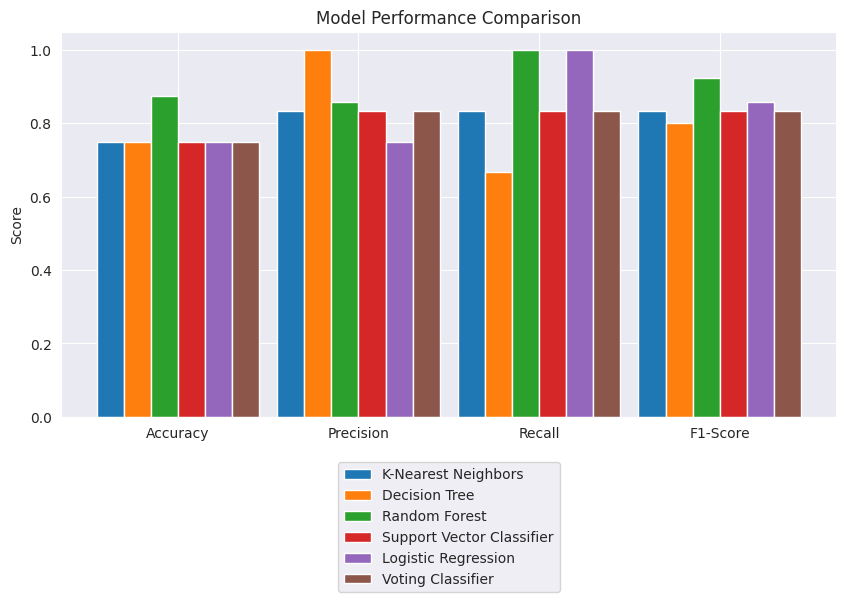

In [209]:
models = list(test_metrics.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

values = [[test_metrics[m][metric] for metric in metrics] for m in models]

x = range(len(metrics))
bar_width = 0.15

plt.figure(figsize=(10, 5))
for i, model in enumerate(models):
    plt.bar(
        [p + i * bar_width for p in x],
        values[i],
        width=bar_width,
        label=model
    )

plt.xticks([p + bar_width * (len(models) - 1) / 2 for p in x], metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend(loc="upper center",  bbox_to_anchor=(0.5, -0.1))
plt.show()


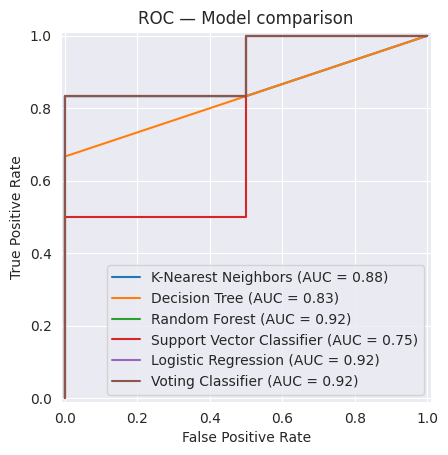

In [208]:
fig, ax = plt.subplots()

for name, model in final_models.items():
    RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        ax=ax,
        name=name,
        pos_label=1
    )

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC — Model comparison")
ax.legend(loc="lower right")
plt.show()

As we can see in this case it is just comparable to the rest of the models.